In [278]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
from scipy.optimize import minimize, fmin
from astropy.wcs import WCS

In [4]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)

In [24]:
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=13, 
    width=13, 
    do_pca=True, 
    do_psf=False,
    time_arr=time, 
    data_arr=tpfs, 
    err_arr=errs, 
    bkg_arr=bkgs, 
)
photometry_flux = sc.to_lightcurve().flux[sq][start:end]

In [20]:
prf = eleanor.prf.make_prf_from_source(star)

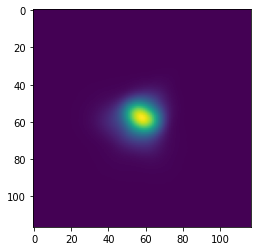

In [55]:
plt.imshow(prf)

In [279]:
test_model = eleanor.models.Zernike(
            shape=(15, 15), 
            col_ref=0, 
            row_ref=0, 
            xc = [8],
            yc = [8],
            fit_idx = 0,
            bkg0 = bkgs[0],
            num_params = 10,
        )
model = test_model
p = np.concatenate(([0, 0], model.get_default_optpars()))
def fit(prf):
    def loss(pars):
        #if abs(pars[0]) > 2 or abs(pars[1]) > 2:
        #    return np.inf
        return np.sum((prf - model.evaluate(1, pars))**2)

    res = fmin(loss, p, maxiter=2000)#, method='Nelder-Mead')
    return res, loss

In [276]:
to_fit = model.evaluate(1, np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [280]:
model.zernike(4)

array([[  -1.73205081,    1.73205081,   12.12435565,   29.44486373,
          53.69357503,   84.87048957,  122.97560734,  168.00892833,
         219.97045256,  278.86018002,  344.67811071,  417.42424462,
         497.09858177,  583.70112215,  677.23186576],
       [   1.73205081,    5.19615242,   15.58845727,   32.90896534,
          57.15767665,   88.33459119,  126.43970895,  171.47302995,
         223.43455418,  282.32428163,  348.14221232,  420.88834624,
         500.56268339,  587.16522377,  680.69596737],
       [  12.12435565,   15.58845727,   25.98076211,   43.30127019,
          67.5499815 ,   98.72689603,  136.8320138 ,  181.86533479,
         233.82685902,  292.71658648,  358.53451717,  431.28065108,
         510.95498823,  597.55752861,  691.08827222],
       [  29.44486373,   32.90896534,   43.30127019,   60.62177826,
          84.87048957,  116.04740411,  154.15252187,  199.18584287,
         251.1473671 ,  310.03709455,  375.85502524,  448.60115916,
         528.27549631,

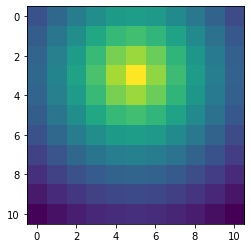

In [203]:
plt.imshow(to_fit)

In [187]:
fit(to_fit)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 190


(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 <function __main__.fit.<locals>.loss(pars)>)

In [157]:
r, l = fit(prf)

Optimization terminated successfully.
         Current function value: 7.935144
         Iterations: 1211
         Function evaluations: 1868


In [160]:
l(0.25 * r)

8.140904464609653

In [165]:
np.sum(model.evaluate(1, 59-r[0], 59-r[1], 0.25*r[2:]))

0.9999999999999999

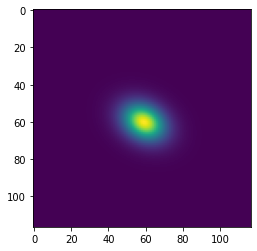

In [158]:
plt.imshow(model.evaluate(1, 59-r[0], 59-r[1], 0.25*r[2:]))

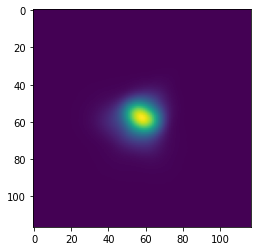

In [149]:
plt.imshow(prf)

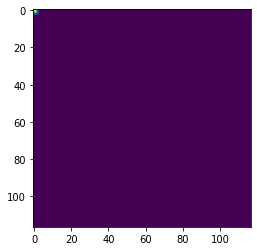

In [83]:
plt.imshow(model.evaluate(1, res.x[0], res.x[1], res.x[2:]))

In [16]:
data.psf_lightcurve(flux_arr=photometry_flux.value, model_name='Gaussian', bkg_mag_cutoff=10, verbose=True)

100%|██████████| 900/900 [02:58<00:00,  5.04it/s]
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636


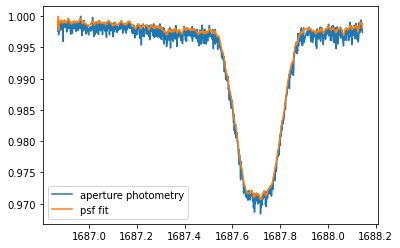

In [17]:
plt.plot(time, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time, data.psf_flux[:end-start] / np.max(data.psf_flux[:end-start]), label='psf fit')
plt.legend()
plt.show()

In [18]:
data.psf_params

array([-0.03284687, -0.01958083,  0.67704575, -0.00439924,  0.73247635])

In [19]:
data.arma_res

     fun: 193446371001.04636
     jac: array([0., 0., 0., 0., 0., 0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 8
     nit: 0
  status: 0
 success: True
       x: array([1., 1., 1., 1., 1., 1., 1.])

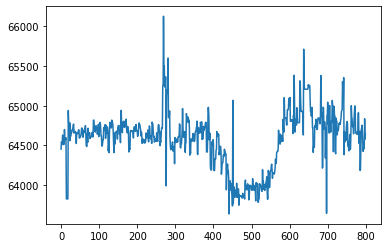

In [32]:
plt.plot(data.naive_psf_flux[2,100:])

In [115]:
gaussian_model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0, 
            xc = [4.51646021, 4.3177313, 4.10392764],
            yc = [6.52438976, 2.51141035, 3.87952034],
            fit_idx = 2,
            bkg0 = bkgs[0]
        )

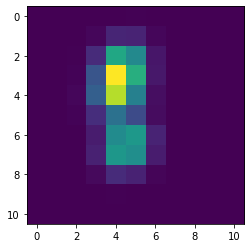

In [116]:
plt.imshow(gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8]))

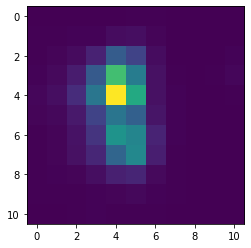

In [117]:
plt.imshow(tpfs[0])

In [120]:
model_tpf0 = gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8])

In [171]:
from functools import reduce

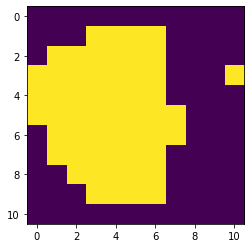

In [174]:
plt.imshow(reduce(np.bitwise_or, np.array([b < d for (b, d) in zip(bkgs, tpfs)])))